## ECE1513 Tutorial 3:
### Generating synthetic data, PCA with sklearn and numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Section 1: Generating Synthetic Data


In [2]:
# Generate synthetic regression data with 3 features and some noise for realism
X, y = make_regression(n_samples=100, n_features=3, noise=10, random_state=42)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 3) (20, 3) (80,) (20,)


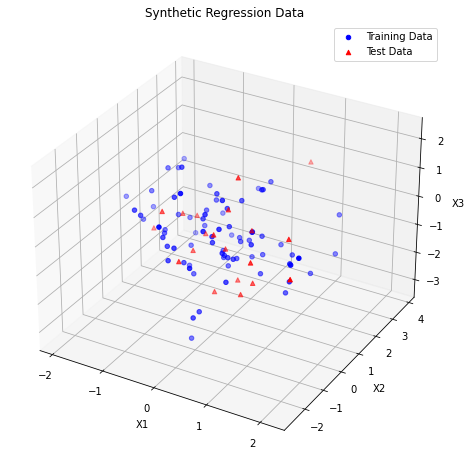

In [3]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='blue', marker='o', label='Training Data')

ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='red', marker='^', label='Test Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Synthetic Regression Data')
ax.legend()

plt.show()

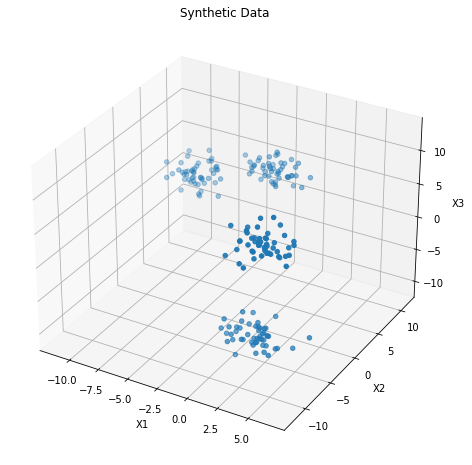

In [4]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=200, n_features=3, centers=4, cluster_std=1.2, random_state=42)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], 'o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Synthetic Data')
plt.show()

### Section 2: PCA Implementation

#### PCA with sklearn

In [5]:
pca = PCA(n_components=2)
# Center the original data for proper alignment
X_train_centered = X_train - np.mean(X_train, axis=0)
X_train_centered = X_train_centered/np.std(X_train_centered, axis=0)
X_test_centered = X_test - np.mean(X_test, axis=0)
X_test_centered = X_test_centered/np.std(X_test_centered, axis=0)

X_train_pca = pca.fit_transform(X_train_centered)  # Fit PCA on training data and transform it
X_test_pca = pca.transform(X_test_centered)  # Transform test data using the same PCA model

# Print the variance explained by each principal component
print("Explained Variance Ratios:", pca.explained_variance_ratio_)

Explained Variance Ratios: [0.38910482 0.35441468]


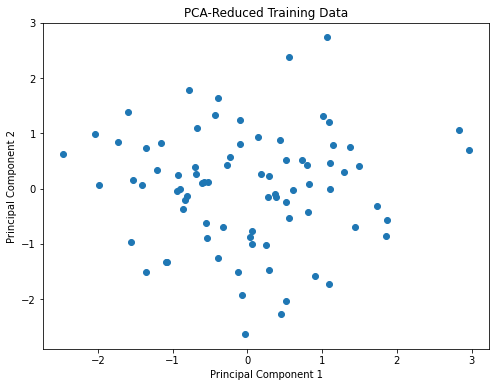

In [6]:
# Visualize the PCA-transformed training data
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])

plt.title('PCA-Reduced Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

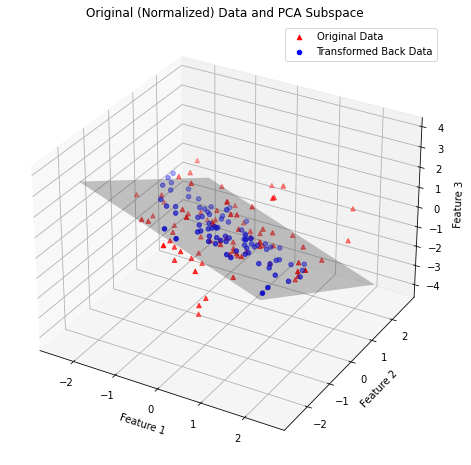

In [7]:
# Get the principal components from the PCA object
pca_components = pca.components_  # Principal axes in feature space

# Compute the normal vector to the PCA plane (cross product of the first two principal components)
plane_normal = np.cross(pca_components[0], pca_components[1])

# Compute the offset (d) for the plane equation: a(x−x0) + b(y−y0) + c(z−z0)=0
# => ax + by + cz + d = 0, where d = −(ax0 + by0 + cz0)
d = -np.mean(X_train_centered, axis=0) @ plane_normal # d should be zero if the data is centered

# Create a grid for visualization
x = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 10)
y = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 10)
x, y = np.meshgrid(x, y)
z = (-plane_normal[0] * x - plane_normal[1] * y - d) / plane_normal[2]  # Solve for z

# Transform the PCA-reduced data back to the original feature space
X_train_transformed_back = pca.inverse_transform(X_train_pca)  # Transform back to the original feature space

# Plot the plane along with the data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_centered[:, 0], X_train_centered[:, 1], X_train_centered[:, 2], c='red', marker='^', label='Original Data')
ax.scatter(X_train_transformed_back[:, 0], X_train_transformed_back[:, 1], X_train_transformed_back[:, 2], c='blue', marker='o', label='Transformed Back Data')
ax.plot_surface(x, y, z, alpha=0.3, color='gray')

# Add labels and legend
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('Original (Normalized) Data and PCA Subspace')
ax.legend()

plt.show()

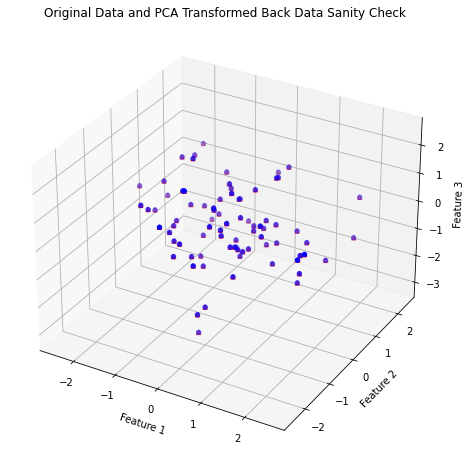

In [8]:
#Sanity Check: Use PCA with all components and transform the data back and compare with the original data
pca = PCA(n_components=3)
X_train_centered = X_train - np.mean(X_train, axis=0)
X_train_centered = X_train_centered/np.std(X_train_centered, axis=0)
X_test_centered = X_test - np.mean(X_test, axis=0)
X_test_centered = X_test_centered/np.std(X_test_centered, axis=0)

X_train_pca = pca.fit_transform(X_train_centered)
X_test_pca = pca.transform(X_test_centered)
X_train_transformed_back = pca.inverse_transform(X_train_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_centered[:, 0], X_train_centered[:, 1], X_train_centered[:, 2], c='red', marker='^', label='Original Data')
ax.scatter(X_train_transformed_back[:, 0], X_train_transformed_back[:, 1], X_train_transformed_back[:, 2], c='blue', marker='o', label='Transformed Back Data')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('Original Data and PCA Transformed Back Data Sanity Check')
plt.show()

#### PCA Implementation Using SVD (Singular Value Decomposition)

Singular Values from SVD: [9.6635996  9.22277194 7.84571988]
Explained variance ratio: [0.38910482 0.35441468 0.2564805 ]


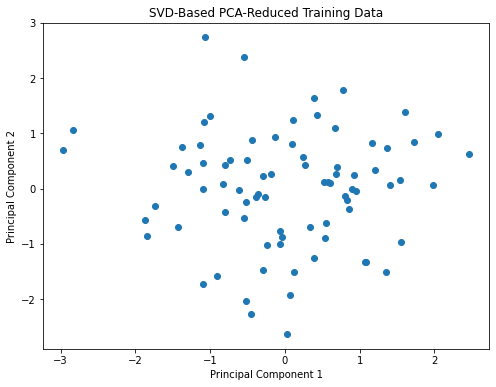

In [9]:
def pca_with_svd(X, n_components):
    """
    Perform PCA using Singular Value Decomposition (SVD).

    Parameters:
        X (np.ndarray): Input data.
        n_components (int): Number of principal components to retain.

    Returns:
        np.ndarray: Transformed data in reduced dimensional space.
        np.ndarray: Singular values.
        np.ndarray: Principal components.
    """
    # Center the data by subtracting the mean of each feature
    X_centered = X - np.mean(X, axis=0)
    X_centered = X_centered/np.std(X_centered, axis=0)

    # Perform SVD on the centered data
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    
    # Select the top n_components principal components
    X_reduced = X_centered @ Vt[:n_components, :].T
    ## Or equivalently, X_reduced = U[:, :n_components] @ np.diag(S[:n_components])
    # X_reduced = U[:, :n_components] @ np.diag(S[:n_components])
    
    return X_reduced, S, Vt[:n_components, :]

# Apply SVD-based PCA on the training data
X_train_pca_svd, S, Vt = pca_with_svd(X_train, n_components=2)
X_test_pca_svd = X_test @ Vt.T

print("Singular Values from SVD:", S)
print("Explained variance ratio:", S**2/np.sum(S**2))

# Visualize the SVD-based PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca_svd[:, 0], X_train_pca_svd[:, 1])

plt.title('SVD-Based PCA-Reduced Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

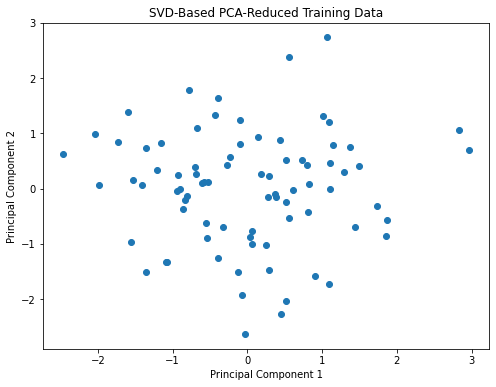

In [10]:
# There could be a sign difference between the PCA and SVD-based PCA results; let's see if they are equivalent!
plt.figure(figsize=(8, 6))
plt.scatter(-X_train_pca_svd[:, 0], X_train_pca_svd[:, 1])

plt.title('SVD-Based PCA-Reduced Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

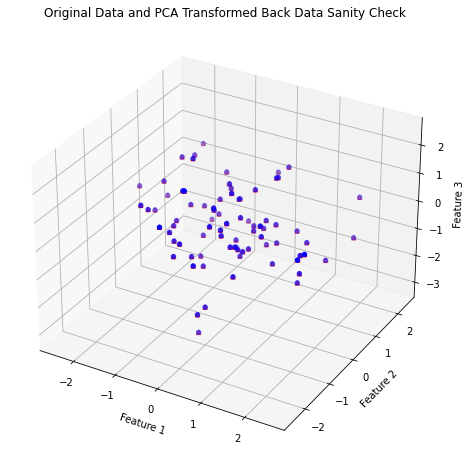

In [11]:
#Sanity Check: Use PCA with all components and transform the data back and compare with the original data
X_train_pca_svd, S, Vt = pca_with_svd(X_train, n_components=3)

X_train_transformed_back = X_train_pca_svd @ Vt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_centered[:, 0], X_train_centered[:, 1], X_train_centered[:, 2], c='red', marker='^', label='Original Data')
ax.scatter(X_train_transformed_back[:, 0], X_train_transformed_back[:, 1], X_train_transformed_back[:, 2], c='blue', marker='o', label='Transformed Back Data')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('Original Data and PCA Transformed Back Data Sanity Check')
plt.show()